This notebook aims to predict blood pressure using bioimpedance measurements from graphene electronic tattoos.

For more detail and access to the data read this [article](https://physicsworld.com/a/graphene-tattoo-provides-cuffless-blood-pressure-monitoring/).

### **1. Data Exploration and Preprocessing**

### **1.1 Creating a combined dataset from the CSVs**

The goal of this section is to combine all of the CSVs into one pandas dataframe with the following schema:

***Subject, Day, SetupType, Setup, Trial, Time, Bioz, FinapresBP***

Each individual trial will be identified by the combination of the Subject, Day and Trial keys.

In [1]:
import pandas as pd
import os 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

>##### **Lets start by reading the data related to one patient and setup.**

In [2]:
# The path to the setup results
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0/subject1_day1/setup01_baseline"

csv_files_finapresBP = glob.glob(os.path.join(path, "*finapresBP.csv"))
csv_files_bioz = glob.glob(os.path.join(path, "*bioz.csv"))

# Combine both lists
csv_files = csv_files_finapresBP + csv_files_bioz

# A list to collect DataFrames
dfs = []

# Loop over the list of csv files 
for f in csv_files: 

    # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
    f = f.replace("\\", "/")

    # Extract the trial, setup and subject info from the file path
    trial_string = f.split("/")[-1]
    setup_string = f.split("/")[-2]
    subject_string = f.split("/")[-3]

    # Process the strings into keys
    trial = int(trial_string.split('_')[1].replace('trial', ''))
    setup_type = setup_string.split('_')[1]  # Include the type of experiment done

    # Read the csv file and add the ids used to identify the experiment
    next_df = pd.read_csv(f)
    next_df['Subject'] = subject_string
    next_df['SetupType'] = setup_type
    next_df['Setup'] = setup_string
    next_df['Trial'] = trial  # Should be shared across files from the same trial

    dfs.append(next_df)

# Concatenate the dataframes into one
df = pd.concat(dfs, ignore_index=True)

df

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
0,2.004923,98.48315,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
1,2.009923,98.14744,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
2,2.014923,97.80030,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
3,2.019923,97.44237,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
4,2.024923,97.07431,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
250334,87.596021,NaN,subject1_day1,baseline,setup01_baseline,1,-63.81312,-24.29105,4.84010,-8.15857
250335,87.596821,NaN,subject1_day1,baseline,setup01_baseline,1,-63.46248,-24.14836,5.12880,-8.18565
250336,87.597621,NaN,subject1_day1,baseline,setup01_baseline,1,-63.10261,-24.00241,5.41779,-8.21183
250337,87.598421,NaN,subject1_day1,baseline,setup01_baseline,1,-62.73376,-23.85328,5.70698,-8.23710


> ##### **An overview of the current dataset.**

In [3]:
# Set the Seaborn Style
sns.set_style("whitegrid")

In [4]:
display(df)
df.info()
df.describe()

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
0,2.004923,98.48315,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
1,2.009923,98.14744,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
2,2.014923,97.80030,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
3,2.019923,97.44237,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
4,2.024923,97.07431,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
250334,87.596021,NaN,subject1_day1,baseline,setup01_baseline,1,-63.81312,-24.29105,4.84010,-8.15857
250335,87.596821,NaN,subject1_day1,baseline,setup01_baseline,1,-63.46248,-24.14836,5.12880,-8.18565
250336,87.597621,NaN,subject1_day1,baseline,setup01_baseline,1,-63.10261,-24.00241,5.41779,-8.21183
250337,87.598421,NaN,subject1_day1,baseline,setup01_baseline,1,-62.73376,-23.85328,5.70698,-8.23710


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250339 entries, 0 to 250338
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        250339 non-null  float64
 1   FinapresBP  33839 non-null   float64
 2   Subject     250339 non-null  object 
 3   SetupType   250339 non-null  object 
 4   Setup       250339 non-null  object 
 5   Trial       250339 non-null  int64  
 6   BioZ1       216500 non-null  float64
 7   BioZ2       216500 non-null  float64
 8   BioZ3       216500 non-null  float64
 9   BioZ4       216500 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 19.1+ MB


,time,FinapresBP,Trial,BioZ1,BioZ2,BioZ3,BioZ4
count,250339.000000,33839.000000,250339.000000,216500.000000,216500.000000,216500.000000,216500.000000
mean,44.299563,100.468637,1.499998,25.550801,9.075036,10.228314,3.341454
std,24.921961,14.259206,0.500001,42.981838,15.749782,15.668690,5.928609
min,1.000021,70.307840,1.000000,-84.635750,-31.683900,-40.261580,-15.341980
25%,22.718821,88.941565,1.000000,-3.573203,-1.582795,-0.110363,-0.917353
50%,44.299923,98.811970,1.000000,39.825125,14.179090,11.960885,4.429660
75%,65.880421,111.115920,2.000000,60.602902,21.819870,20.173572,7.746480
max,87.599221,136.984660,2.000000,94.314210,38.766850,62.628790,18.657800


Show the correlation matrix of each of the variables.

In [5]:
def plot_correlation_matrix(df, columns):
    correlation_matrix = df[columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.show()

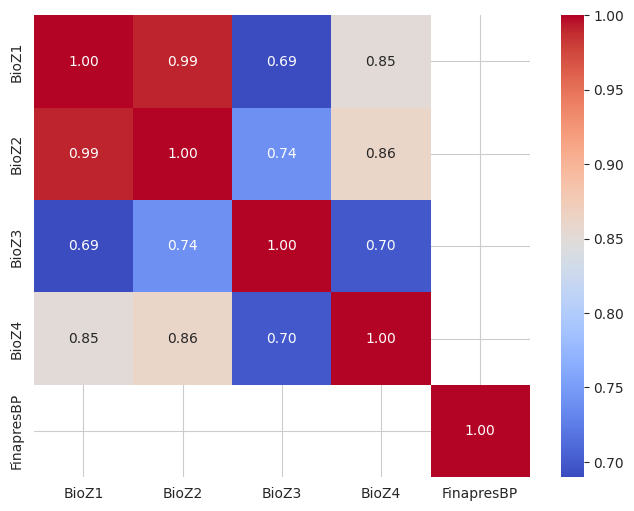

In [6]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_correlation_matrix(df, columns_to_plot)

There is no correlation between the BioZ measurements and FinapresBP because the time measurements do share overlapping timestamps (whenever one has values the other has NaNs).

In [7]:
display(df[df['FinapresBP'].notna()])
display(df[df['BioZ1'].notna()])

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
0,2.004923,98.48315,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
1,2.009923,98.14744,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
2,2.014923,97.80030,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
3,2.019923,97.44237,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
4,2.024923,97.07431,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN


,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
33839,1.000021,NaN,subject1_day1,baseline,setup01_baseline,2,54.75861,19.28289,28.37978,9.61708
33840,1.000821,NaN,subject1_day1,baseline,setup01_baseline,2,54.88802,19.34258,28.47379,9.61511
33841,1.001621,NaN,subject1_day1,baseline,setup01_baseline,2,55.01903,19.40285,28.56771,9.61298
33842,1.002421,NaN,subject1_day1,baseline,setup01_baseline,2,55.15161,19.46372,28.66151,9.61069
33843,1.003221,NaN,subject1_day1,baseline,setup01_baseline,2,55.28571,19.52515,28.75516,9.60825
...,...,...,...,...,...,...,...,...,...,...
250334,87.596021,NaN,subject1_day1,baseline,setup01_baseline,1,-63.81312,-24.29105,4.84010,-8.15857
250335,87.596821,NaN,subject1_day1,baseline,setup01_baseline,1,-63.46248,-24.14836,5.12880,-8.18565
250336,87.597621,NaN,subject1_day1,baseline,setup01_baseline,1,-63.10261,-24.00241,5.41779,-8.21183
250337,87.598421,NaN,subject1_day1,baseline,setup01_baseline,1,-62.73376,-23.85328,5.70698,-8.23710


>##### **I'll visualise one trial to get an understanding of the data.**

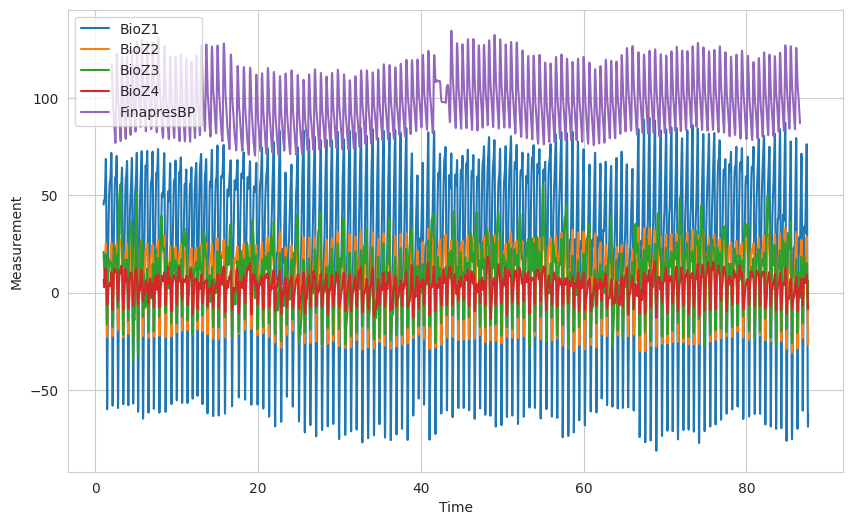

In [8]:
trial1_df = df[df['Trial'] == 1]
# Create the plot
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=trial1_df, x='time', y=column, label=column)

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()

plt.show()

It's a bit cluttered. For more detail I'll limit it to a 5 second stretch

In [55]:
def plot_measurements(df, start_time, end_time, hue=False):

    # Filter the DataFrame by time
    plot_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

    # Create the plot
    plt.figure(figsize=(10, 6))

    for column in columns_to_plot:
        sns.lineplot(data=plot_df, x='time', y=column, label=column, hue=hue)

    plt.xlabel('Time')
    plt.ylabel('Measurement')
    plt.legend()
    plt.show()

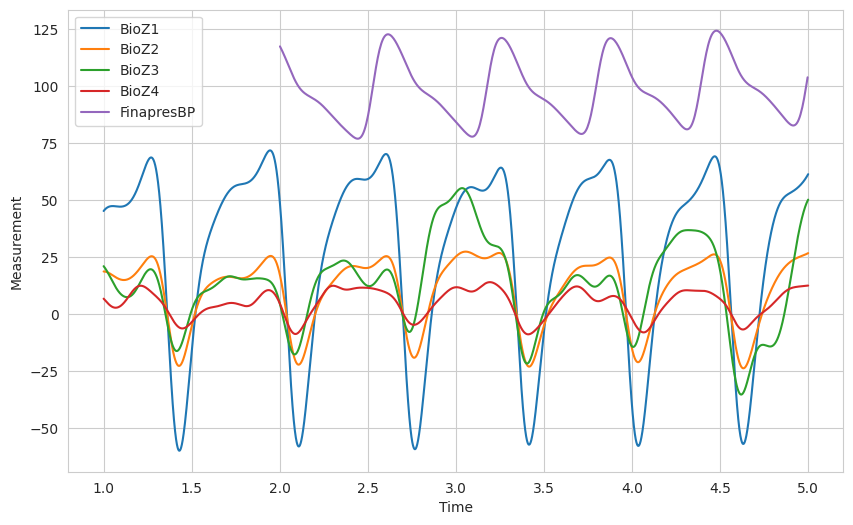

In [10]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(trial1_df, 0, 5)

We can see that the *FinapresBP* measurements start after the *BioZ* measurements.

Lets plot each Measurement directly against Blood Pressure.

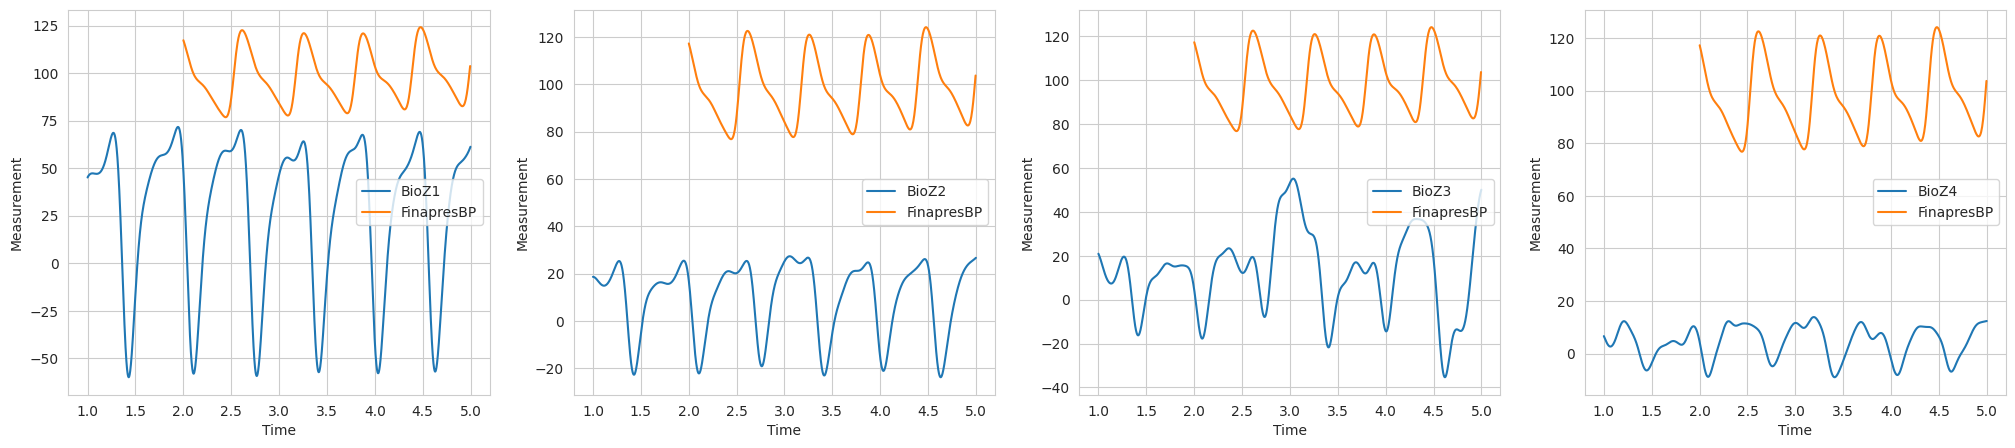

In [11]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(25, 5))

plot_df = trial1_df[(trial1_df['time'] >= 0) & (trial1_df['time'] <= 5)]

for ax, column in zip(axs, columns_to_plot):
    sns.lineplot(data=plot_df, x='time', y=column, label=column, ax=ax)
    sns.lineplot(data=plot_df, x='time', y='FinapresBP', label='FinapresBP', ax=ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Measurement')
    ax.legend(loc='center right')

plt.show()

The two types of measurement also seem to be slightly out of phase, due to the sensor's different position on the arm.

### **1.2 Constuct a Common Time Axis**

I am going to repeat the approach from the starter notebook to create a shared time axis.

This will be shown using the first trial.

In [12]:
trial1_df = df[df['Trial']==1]
bioz_df = trial1_df.drop(columns='FinapresBP').dropna()
bp_df = trial1_df.drop(columns=['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']).dropna()
display(bioz_df)
display(bp_df)

,time,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
142089,1.000021,subject1_day1,baseline,setup01_baseline,1,45.11402,18.60437,20.92109,6.67912
142090,1.000821,subject1_day1,baseline,setup01_baseline,1,45.19330,18.60317,20.84464,6.61070
142091,1.001621,subject1_day1,baseline,setup01_baseline,1,45.27085,18.60096,20.76674,6.54201
142092,1.002421,subject1_day1,baseline,setup01_baseline,1,45.34667,18.59775,20.68740,6.47308
142093,1.003221,subject1_day1,baseline,setup01_baseline,1,45.42077,18.59353,20.60664,6.40395
...,...,...,...,...,...,...,...,...,...
250334,87.596021,subject1_day1,baseline,setup01_baseline,1,-63.81312,-24.29105,4.84010,-8.15857
250335,87.596821,subject1_day1,baseline,setup01_baseline,1,-63.46248,-24.14836,5.12880,-8.18565
250336,87.597621,subject1_day1,baseline,setup01_baseline,1,-63.10261,-24.00241,5.41779,-8.21183
250337,87.598421,subject1_day1,baseline,setup01_baseline,1,-62.73376,-23.85328,5.70698,-8.23710


,time,FinapresBP,Subject,SetupType,Setup,Trial
16919,2.000961,117.25990,subject1_day1,baseline,setup01_baseline,1
16920,2.005961,116.50575,subject1_day1,baseline,setup01_baseline,1
16921,2.010961,115.71514,subject1_day1,baseline,setup01_baseline,1
16922,2.015961,114.89302,subject1_day1,baseline,setup01_baseline,1
16923,2.020961,114.04378,subject1_day1,baseline,setup01_baseline,1
...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1


> ##### **Interpolate the data onto a common time axis.**

In [13]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [14]:
start_time = max(min(bioz_df['time']), min(bp_df['time']))
end_time = min(max(bioz_df['time']), max(bp_df['time']))
common_time = np.linspace(start_time, end_time, num=len(bp_df))  # Instead of 1000 I will match the sampling rate of the Finapres data

finapres_interpolator = interp1d(bp_df['time'], bp_df['FinapresBP'], bounds_error=False, fill_value="extrapolate")
bioz1_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ1'], bounds_error=False, fill_value="extrapolate")
bioz2_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ2'], bounds_error=False, fill_value="extrapolate")
bioz3_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ3'], bounds_error=False, fill_value="extrapolate")
bioz4_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ4'], bounds_error=False, fill_value="extrapolate")

finapres_common = finapres_interpolator(common_time)
bioz1_common = bioz1_interpolator(common_time)
bioz2_common = bioz2_interpolator(common_time)
bioz3_common = bioz3_interpolator(common_time)
bioz4_common = bioz4_interpolator(common_time)

Create a dataframe with the new time axis.

In [15]:
bp_df['BioZ1'] = bioz1_common
bp_df['BioZ2'] = bioz2_common
bp_df['BioZ3'] = bioz3_common
bp_df['BioZ4'] = bioz4_common

bp_df

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
16919,2.000961,117.25990,subject1_day1,baseline,setup01_baseline,1,48.332439,16.943260,4.337878,4.415633
16920,2.005961,116.50575,subject1_day1,baseline,setup01_baseline,1,43.384880,15.087782,2.756093,3.484722
16921,2.010961,115.71514,subject1_day1,baseline,setup01_baseline,1,37.969078,13.056467,1.085794,2.508537
16922,2.015961,114.89302,subject1_day1,baseline,setup01_baseline,1,32.123190,10.864834,-0.655107,1.496772
16923,2.020961,114.04378,subject1_day1,baseline,setup01_baseline,1,25.896649,8.532647,-2.445484,0.460766
...,...,...,...,...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1,20.277790,4.039298,-2.759994,-1.125975
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1,20.673994,4.207431,-2.845577,-1.102570
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1,21.228864,4.447118,-2.823403,-1.051217
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1,21.935641,4.756011,-2.693616,-0.973220


Now that they share an axis the correlation between the ***BioZ*** and ***FinapresBP*** measurements can be examined.

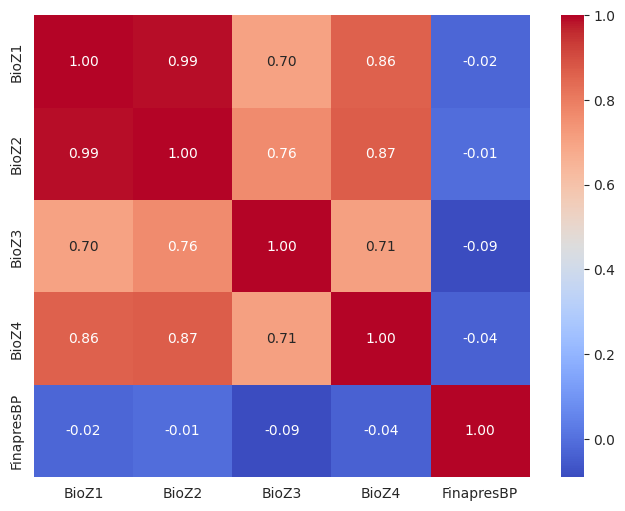

In [16]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']
plot_correlation_matrix(bp_df, columns_to_plot)

The correlation is quite low, this is most likely because the two measurements are still out of phase.

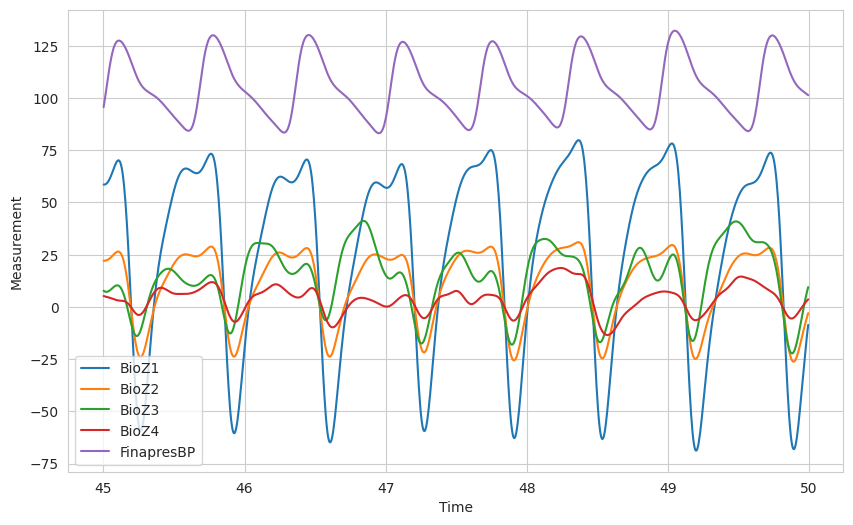

In [17]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']
plot_measurements(bp_df, 45, 50)

Lets try a regression.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
features = bp_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = bp_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 5.6739049845153655
Root Mean Squared Error: 8.279149191716565
R^2 Score: 0.6438913430721231


I'll try to improve this by making them in-phase.

> ##### **Use Cross-Correlation to align the series.**

As different, subjects might have different gaps between the measurements, I'll use cross-correlation to align the different measurements instead of a hard-coded shift.

Cross correlation compares each series at every time lag, essentially finding out how a series should be shifted to maximise correlation.

In [20]:
from scipy.signal import correlate

In [21]:
def cross_correlate(series1, series2, plot=False):

    # Normalise the series, as they each have different scales  #https://stackoverflow.com/questions/53436231/normalized-cross-correlation-in-python
    series1 = (series1 - np.mean(series1)) / (np.std(series1))
    series2 = (series2 - np.mean(series2)) / (np.std(series2))
    lags = np.arange(-len(series1) + 1, len(series1))
    cross_correlation = correlate(series1, series2, mode='full')

    # Find the lag with the maximum correlation
    lag_max = lags[cross_correlation.argmax()]

    # Calculate the length of the misalignment in time
    time_difference = np.diff(bp_df['time'])
    average_delta_time = np.mean(time_difference)
    lag_time = lag_max * average_delta_time

    if plot:
        # Plot cross-correlation
        plt.figure(figsize=(10, 5))
        plt.plot(lags, cross_correlation)
        plt.title('Cross-correlation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coefficient')
        plt.axvline(x=lag_max, color='r', linestyle='--')
        # plt.xlim(-100, 100)
        plt.show()

        print(f"The maximum correlation is at lag {lag_max}, which equates to {lag_time:.4f} seconds.")

    return lag_max

Invert the BioZ measurement to find the maximum correlation with Blood Pressure.

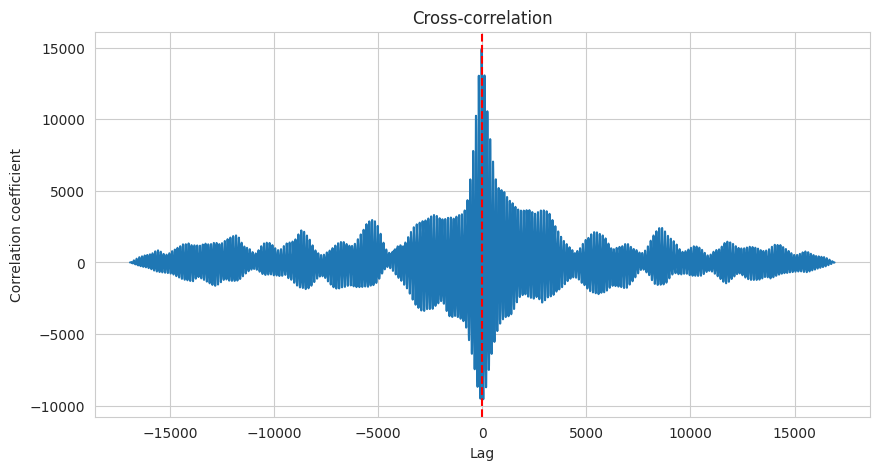

The maximum correlation is at lag -30, which equates to -0.1500 seconds.


-30

In [22]:
cross_correlate(bp_df['FinapresBP'], -1 * bp_df['BioZ1'], plot=True)

As the most highly correlated lag is negative this tells us that the ***BioZ1*** measurements occur 0.15 seconds after the ***FinpresBP*** measurements (Correlation is maximised when ***BioZ1*** is shifted back in time).

This goes against the initial hypothesis that the blood pressure measurements occur after the BioZ measurements, due to the sensor's more distant position from the heart, but I'll stick with it for now.

We can also check if the BioZ measurements are out of phase.

In [23]:
print("Cross-correlation between BioZ1 and BioZ2: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ2'])))
print("Cross-correlation between BioZ1 and BioZ3: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ3'])))
print("Cross-correlation between BioZ1 and BioZ4: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ4'])))

Cross-correlation between BioZ1 and BioZ2: 0
Cross-correlation between BioZ1 and BioZ3: 4
Cross-correlation between BioZ1 and BioZ4: 1


BioZ 1 and 2 also occur slightly after 3 and 4.

I'll align all 4 BioZ metrics to FinapresBP in order to maximise the correlation and hopefully improve regression performance.

In [24]:
aligned_df = bp_df.copy()  # Copy to avoid shifting the original df

# Shift the values based on their lag to FinapresBP
aligned_df['BioZ1'] = aligned_df['BioZ1'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ1']))
aligned_df['BioZ2'] = aligned_df['BioZ2'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ2']))
aligned_df['BioZ3'] = aligned_df['BioZ3'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ3']))
aligned_df['BioZ4'] = aligned_df['BioZ4'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ4']))

In [25]:
display(aligned_df)

# Drop the rows with NaNs at the end caused by the shift
aligned_df = aligned_df.dropna()
display(aligned_df)

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
16919,2.000961,117.25990,subject1_day1,baseline,setup01_baseline,1,-38.533330,-14.585256,-10.377965,-3.523223
16920,2.005961,116.50575,subject1_day1,baseline,setup01_baseline,1,-34.658723,-13.120392,-8.771153,-2.842555
16921,2.010961,115.71514,subject1_day1,baseline,setup01_baseline,1,-30.661121,-11.614628,-7.086624,-2.168193
16922,2.015961,114.89302,subject1_day1,baseline,setup01_baseline,1,-26.593230,-10.087884,-5.347416,-1.504652
16923,2.020961,114.04378,subject1_day1,baseline,setup01_baseline,1,-22.502636,-8.558192,-3.576163,-0.854642
...,...,...,...,...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN


,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
16919,2.000961,117.25990,subject1_day1,baseline,setup01_baseline,1,-38.533330,-14.585256,-10.377965,-3.523223
16920,2.005961,116.50575,subject1_day1,baseline,setup01_baseline,1,-34.658723,-13.120392,-8.771153,-2.842555
16921,2.010961,115.71514,subject1_day1,baseline,setup01_baseline,1,-30.661121,-11.614628,-7.086624,-2.168193
16922,2.015961,114.89302,subject1_day1,baseline,setup01_baseline,1,-26.593230,-10.087884,-5.347416,-1.504652
16923,2.020961,114.04378,subject1_day1,baseline,setup01_baseline,1,-22.502636,-8.558192,-3.576163,-0.854642
...,...,...,...,...,...,...,...,...,...,...
33804,86.425961,99.39077,subject1_day1,baseline,setup01_baseline,1,20.277790,4.039298,-0.818189,-1.120395
33805,86.430961,99.04503,subject1_day1,baseline,setup01_baseline,1,20.673994,4.207431,-1.390865,-1.125975
33806,86.435961,98.69012,subject1_day1,baseline,setup01_baseline,1,21.228864,4.447118,-1.878121,-1.102570
33807,86.440961,98.32703,subject1_day1,baseline,setup01_baseline,1,21.935641,4.756011,-2.272390,-1.051217


The last 30 rows are dropped due to the shift of the BioZ measurements.

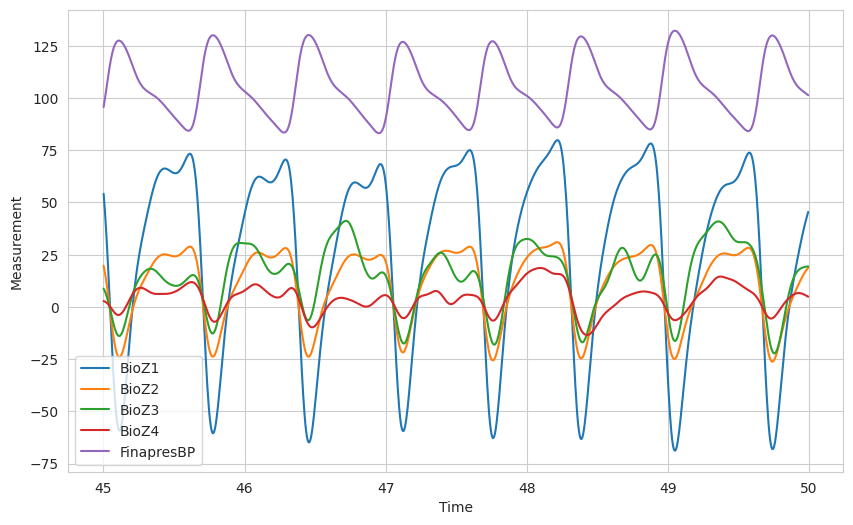

In [26]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(aligned_df, 45, 50)

The spectra now look visually aligned, lets see how the correlation has changed.

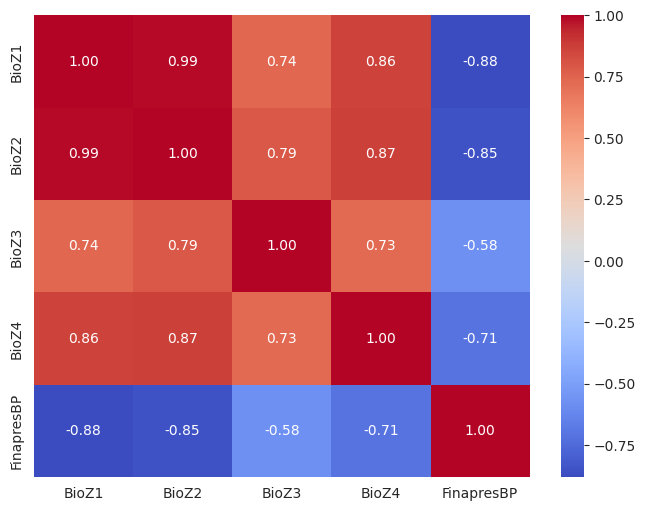

In [27]:
plot_correlation_matrix(aligned_df, columns_to_plot)

That seemed to work, the negative correlation between BioZ and BP has greatly increased.

Lets try the regression again.

In [28]:
features = aligned_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = aligned_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 3.566519977915927
Root Mean Squared Error: 4.834837954319594
R^2 Score: 0.8797910630945056


Aligning the series has greatly improved the regression performance.

> ##### **Test the assumption that *FinaPresBP* comes after *BioZ*.**

Before I perform the interpolation and cross-correlation on every trial, I want to make sure that the correct heartbeats have been aligned.

If ***FinapresBP*** does occur after ***BioZ*** the cross-correlation can be modified to only look at positive lags.

In [29]:
def cross_correlate_positive_only(series1, series2, plot=False):

    # Normalise the series, as they each have different scales  #https://stackoverflow.com/questions/53436231/normalized-cross-correlation-in-python
    series1 = (series1 - np.mean(series1)) / (np.std(series1))
    series2 = (series2 - np.mean(series2)) / (np.std(series2))
    cross_correlation = correlate(series1, series2, mode='full')

    # Only look at the positive half of the cross correlation
    positive_cross_correlation = cross_correlation[len(cross_correlation)//2:]

    # Adjust the lags array to be the size of the positive half
    lags = np.arange(0, len(series1))

    print(len(lags))
    # Find the positive lag with the maximum correlation
    lag_max = lags[positive_cross_correlation.argmax()]

    # Calculate the length of the misalignment in time
    time_difference = np.diff(bp_df['time'])
    average_delta_time = np.mean(time_difference)
    lag_time = lag_max * average_delta_time

    if plot:
        # Plot cross-correlation
        plt.figure(figsize=(10, 5))
        plt.plot(lags, positive_cross_correlation)
        plt.title('Positive Cross-correlation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coefficient')
        plt.axvline(x=lag_max, color='r', linestyle='--')
        # plt.xlim(-100, 100)
        plt.show()

        print(f"The maximum correlation is at lag {lag_max}, which equates to {lag_time:.4f} seconds.")

    return lag_max

16920


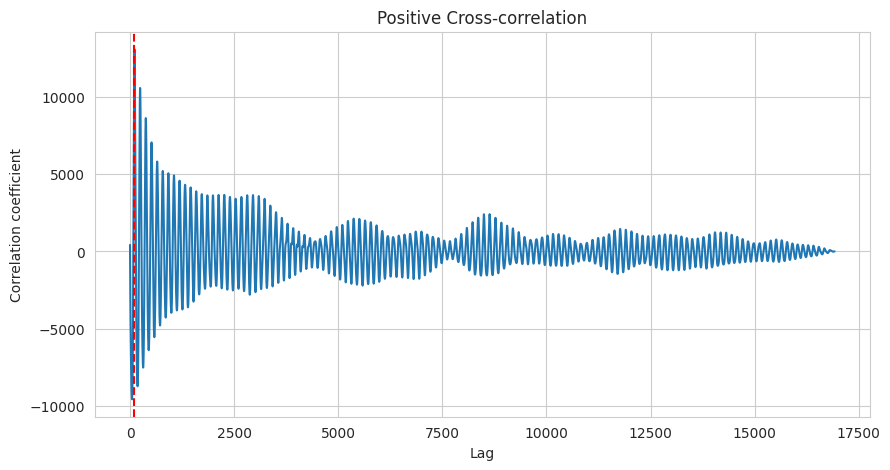

The maximum correlation is at lag 107, which equates to 0.5350 seconds.


107

In [30]:
cross_correlate_positive_only(bp_df['FinapresBP'], -1 * bp_df['BioZ1'], plot=True)

According to this approach, the ***FinapresBP*** measurements occur 0.5350 seconds after the ***BioZ*** measurements.

The BioZ measurements can be shifted back to account for this.

In [31]:
aligned_df = bp_df

# Shift the values based on their lag to FinapresBP
aligned_df['BioZ1'] = bp_df['BioZ1'].shift(cross_correlate_positive_only(bp_df['FinapresBP'], -1 * bp_df['BioZ1']))
aligned_df['BioZ2'] = bp_df['BioZ2'].shift(cross_correlate_positive_only(bp_df['FinapresBP'], -1 * bp_df['BioZ2']))
aligned_df['BioZ3'] = bp_df['BioZ3'].shift(cross_correlate_positive_only(bp_df['FinapresBP'], -1 * bp_df['BioZ3']))
aligned_df['BioZ4'] = bp_df['BioZ4'].shift(cross_correlate_positive_only(bp_df['FinapresBP'], -1 * bp_df['BioZ4']))

16920
16920
16920
16920


In [32]:
display(aligned_df)

# Drop the rows with NaNs at the end caused by the shift
aligned_df = aligned_df.dropna()
display(aligned_df)

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
16919,2.000961,117.25990,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
16920,2.005961,116.50575,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
16921,2.010961,115.71514,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
16922,2.015961,114.89302,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
16923,2.020961,114.04378,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1,56.521973,21.938780,6.793856,4.570112
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1,58.185035,22.680968,7.547988,4.617755
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1,59.849865,23.416500,8.308917,4.667222
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1,61.516974,24.144429,9.071360,4.724163


,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4
17030,2.555961,112.20797,subject1_day1,baseline,setup01_baseline,1,25.896649,8.532647,4.337878,1.496772
17031,2.560961,114.09118,subject1_day1,baseline,setup01_baseline,1,19.354285,6.085352,2.756093,0.460766
17032,2.565961,115.75133,subject1_day1,baseline,setup01_baseline,1,12.571705,3.552295,1.085794,-0.586344
17033,2.570961,117.19370,subject1_day1,baseline,setup01_baseline,1,5.633771,0.966089,-0.655107,-1.630163
17034,2.575961,118.49058,subject1_day1,baseline,setup01_baseline,1,-1.366571,-1.637821,-2.445484,-2.655336
...,...,...,...,...,...,...,...,...,...,...
33834,86.575961,88.07976,subject1_day1,baseline,setup01_baseline,1,56.521973,21.938780,6.793856,4.570112
33835,86.580961,87.74439,subject1_day1,baseline,setup01_baseline,1,58.185035,22.680968,7.547988,4.617755
33836,86.585961,87.43317,subject1_day1,baseline,setup01_baseline,1,59.849865,23.416500,8.308917,4.667222
33837,86.590961,87.15423,subject1_day1,baseline,setup01_baseline,1,61.516974,24.144429,9.071360,4.724163


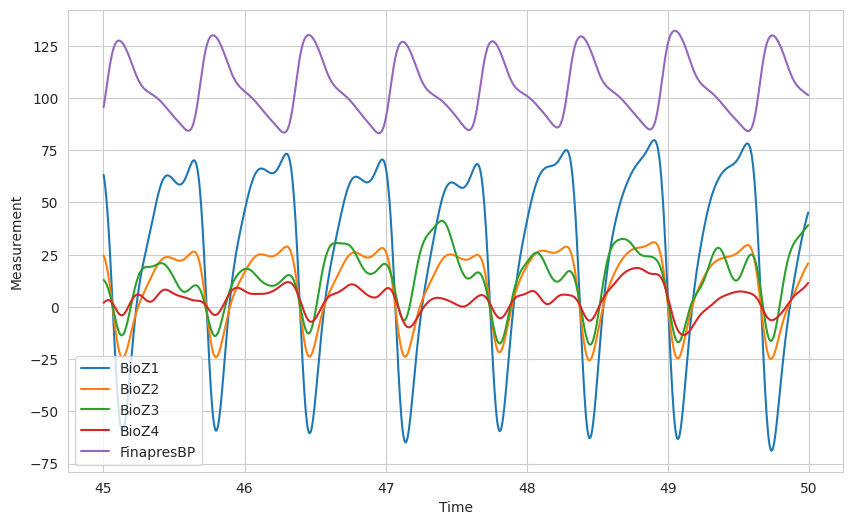

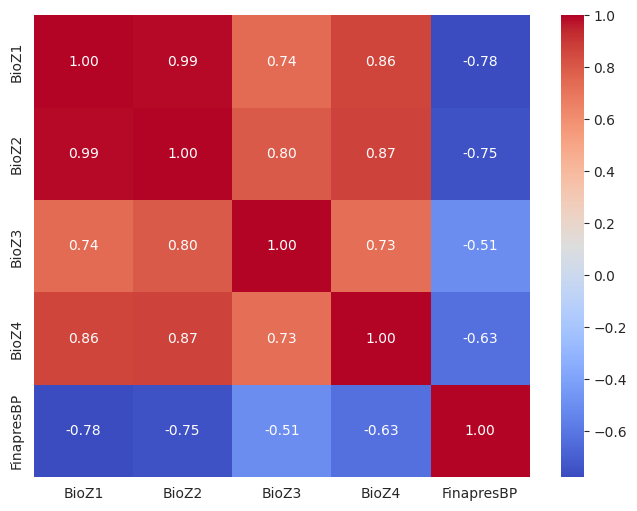

In [33]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(aligned_df, 45, 50)

plot_correlation_matrix(aligned_df, columns_to_plot)

Once, again, the spectra are visually aligned and the correlations have increased.

However the correlations are less significant, lets look at how the regression model performs.

In [34]:
features = aligned_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = aligned_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 5.139353640124925
Root Mean Squared Error: 8.017656650317205
R^2 Score: 0.6725722187618131


This is quite a bit worse.

Based on the lower correlation and worse model performance, I am going to stick with the first approach and follow the assumption that blood pressure measurements occur first.

### **1.2 Now I'll repeat this with all of the CSVs**

> ##### **Load and Interpolate the ***BioZ*** and ***Finapres*** data from every trial.**

Trying to perform interpolation on the fully loaded dataset has too large of a memory footprint, as a result it is done on each trial as it is imported.

In [35]:
def interpolate_trial(bioz_df, bp_df):

    start_time = max(min(bioz_df['time']), min(bp_df['time']))
    end_time = min(max(bioz_df['time']), max(bp_df['time']))
    common_time = np.linspace(start_time, end_time, num=len(bp_df))  # Instead of 1000 I will match the sampling rate of the Finapres data

    #finapres_interpolator = interp1d(bp_df['time'], bp_df['FinapresBP'], bounds_error=False, fill_value="extrapolate")  # Not needed as this axis is left alone
    bioz1_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ1'], bounds_error=False, fill_value="extrapolate")
    bioz2_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ2'], bounds_error=False, fill_value="extrapolate")
    bioz3_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ3'], bounds_error=False, fill_value="extrapolate")
    bioz4_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ4'], bounds_error=False, fill_value="extrapolate")

    # finapres_common = finapres_interpolator(common_time)
    bioz1_common = bioz1_interpolator(common_time)
    bioz2_common = bioz2_interpolator(common_time)
    bioz3_common = bioz3_interpolator(common_time)
    bioz4_common = bioz4_interpolator(common_time)

    bp_df['BioZ1'] = bioz1_common
    bp_df['BioZ2'] = bioz2_common
    bp_df['BioZ3'] = bioz3_common
    bp_df['BioZ4'] = bioz4_common

    return bp_df

In [57]:
dfs = []

# Set this to the to the root folder of the data
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0"

# Get all of the subject folders
subject_folders = glob.glob(os.path.join(path, "*" + os.sep))  # os.sep ensures that only directories are matched

# Iterate over each subject folder and examine each setup folder
for subject_folder in subject_folders:
    setup_folders = glob.glob(os.path.join(subject_folder, "*" + os.sep))

    # Iterate over each setup folder adding the CSVs within
    for setup_folder in setup_folders:
        trial_files = glob.glob(os.path.join(setup_folder, "*.csv"))

        # Create a dictionary mapping trials to their files
        trial_dict = {}
        for f in trial_files:
            f = f.replace("\\", "/")
            trial = f.split("/")[-1].split('_')[1] # Extract the trial name
            if trial in trial_dict:
                trial_dict[trial].append(f)
            else:
                trial_dict[trial] = [f]

        # Process each trial
        for trial, files in trial_dict.items():

            # Get the BioZ and BP measurements
            bioz_file = next((f for f in files if 'bioz.csv' in f), None)
            bp_file = next((f for f in files if 'finapresBP.csv' in f), None)

            if bioz_file and bp_file:  # Ensure both files are found

                # Extract the trial, setup and subject info from the file path
                bioz_file = bioz_file.replace("\\", "/")
                trial_string = bioz_file.split("/")[-1]
                setup_string = bioz_file.split("/")[-2]
                subject_string = bioz_file.split("/")[-3]

                # Process the strings into keys
                trial = int(trial_string.split('_')[1].replace('trial', ''))
                setup_type = setup_string.split('_')[1]  # Include the type of experiment done
                setup = int(setup_string.split('_')[0].replace('setup', ''))

                # Day and subject should also be split so that subject 1 is properly accounted for
                # This should prevent data leakage across folds later on
                day = int(subject_string.split('_')[1].replace("day", ""))
                subject = int(subject_string.split('_')[0].replace("subject", ""))
                
                # Read CSVs and add trial identifiers
                bioz_df = pd.read_csv(bioz_file)
                bp_df = pd.read_csv(bp_file)

                # Add identifiers to DataFrames
                for df in (bioz_df, bp_df):
                    df['Subject'] = subject
                    df['Day'] = day
                    df['SetupType'] = setup_type
                    df['Setup'] = setup
                    df['Trial'] = trial

                # Subject 7 has no BioZ4 measurements so I'll create the column
                if 'BioZ4' not in bioz_df.columns:
                    bioz_df['BioZ4'] = np.nan
                
                # Interpolate and merge bioz into bp dataframe for the trial
                merged_df = interpolate_trial(bioz_df, bp_df)
                dfs.append(merged_df)

            else:
                print('Missing File')
                       
df = pd.concat(dfs, ignore_index=True)

Add a bit more structure to the dataset, ordering columns by granularity.

Additionally, 

In [86]:
df = df[['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'time', 'BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']]
display(df)
df.info()
df.describe()
df.isna().sum()

,Subject,Day,SetupType,Setup,Trial,time,BioZ1,BioZ2,BioZ3,BioZ4,FinapresBP
0,4,1,hgcp,3,12,2.001273,13.448716,-7.072506,25.092134,-2.859797,61.51059
1,4,1,hgcp,3,12,2.006273,14.398632,-7.974001,25.644244,-2.938438,61.43445
2,4,1,hgcp,3,12,2.011273,15.394391,-8.858218,26.312434,-2.953724,61.33912
3,4,1,hgcp,3,12,2.016273,16.429643,-9.726161,27.093175,-2.905668,61.22310
4,4,1,hgcp,3,12,2.021273,17.496892,-10.578904,27.980004,-2.795309,61.08539
...,...,...,...,...,...,...,...,...,...,...,...
4460467,1,1,hgcp,7,29,86.576755,-42.969754,-14.640517,-24.377147,-0.884836,139.61385
4460468,1,1,hgcp,7,29,86.581755,-46.209377,-15.719765,-25.092277,-1.277057,138.12162
4460469,1,1,hgcp,7,29,86.586755,-48.872887,-16.625495,-25.493273,-1.682027,136.61745
4460470,1,1,hgcp,7,29,86.591755,-50.953787,-17.357463,-25.578663,-2.102113,135.11783


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460472 entries, 0 to 4460471
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Subject     int64  
 1   Day         int64  
 2   SetupType   object 
 3   Setup       int64  
 4   Trial       int64  
 5   time        float64
 6   BioZ1       float64
 7   BioZ2       float64
 8   BioZ3       float64
 9   BioZ4       float64
 10  FinapresBP  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 374.3+ MB


Subject            0
Day                0
SetupType          0
Setup              0
Trial              0
time               0
BioZ1              0
BioZ2              0
BioZ3              0
BioZ4         112197
FinapresBP         0
dtype: int64

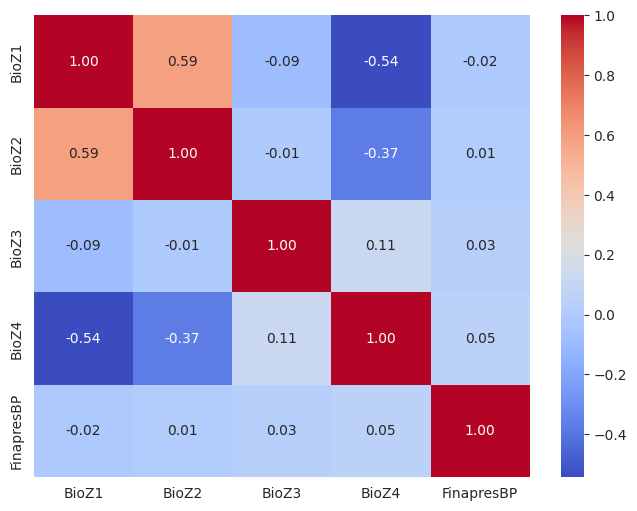

In [50]:
plot_correlation_matrix(df, columns_to_plot)

In [87]:
features = df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

: 

Once again the values have low correlation and need to be aligned.

In [82]:
len(df[['Subject', 'Day', 'Trial']].drop_duplicates())

260